In [9]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.utils.data
import matplotlib.pyplot as plt
import time
import itertools

In [ ]:
!git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
%cd Ranger-Deep-Learning-Optimizer
!pip install -e . 

## To Do:
Now: 
* Turn on scheduler on right time.
* Try new range optimizer that works really well 
* Replace activations with Mish
* Get a resnet 152 algorithm

In future: 
* Choose X Resnet Model with FastAI
* Try different replacements of BatchNorm
* Add Self_attention layer
* Increase Weight Decay
* Build haar cascade to cover human faces.


* Try Following 
https://forums.fast.ai/t/how-we-beat-the-5-epoch-imagewoof-leaderboard-score-some-new-techniques-to-consider/53453

Then try to apply haar cascade to white out human faces.









#### Pip Install and import other packages

In [ ]:
!pip install pytorch_lightning

In [4]:
from pytorch_lightning.metrics import Accuracy, Metric, F1, Precision, Recall, ConfusionMatrix

In [5]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [15]:
#Uncomment to load data in
import tarfile
my_tar = tarfile.open('/content/drive/MyDrive/imagewoof2-160.tgz')
my_tar.extractall() # specify which folder to extract to
my_tar.close()

In [44]:
data_dir = "/content/imagewoof2-160"
batch_size = 64
#Set random seed
np.random.seed(42)
torch.manual_seed(42)

train_transform = transforms.Compose([
                                      transforms.Resize(255),
                                      transforms.RandomCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([
                                     transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, "val"), transform = test_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

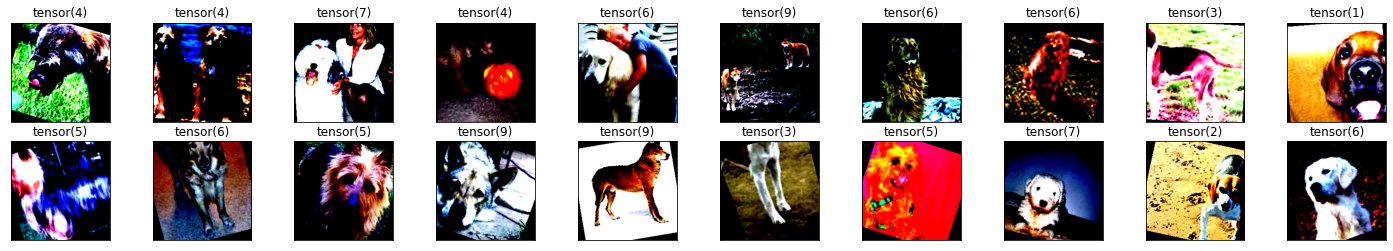

In [45]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(labels[idx])

  

## Explore Data

As an example - are very local features enough or do we need global context? How much variation is there and what form does it take? What variation is spurious and could be preprocessed out? Does spatial position matter or do we want to average pool it out? How much does detail matter and how far could we afford to downsample the images? 

* Global Features are the most important
* Variations (U - means useless for classification, * - Means important)
 * Position of Dogs - U
 * Presence of Human - U
 * Spatial Information - U (Location, Configuration, etc.) Avg Pool Models or Adaptive Avg Pool (or anything to that nature) would work. 
 * Color of the Dog - * 
 * Texture of the Dog - * 
 * Edge Fluffiness - *
 * Shape of face of dog (long face or short face) - *

 POSSIBLE THINGS TO EXPLORE:
 * Use Augmentation to rotate image
 * Use Face Haar Cascade to recognize human and white out face
 (Look in the Dog Breed classifier code to only white out face if it recognizes human). 
 * Use AvgPool in end of layer
 * Use Preprocessing filters that only get edges, color, and texture of dog and put it into an initial image of n amount of feature maps then put it into conv network.

 


## Entire Train and Test Function and Visualizer
Source Confusion Matrix grapher from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

In [21]:
def Graph_Maker(Train_l,Test_L, print_every):
  epoch_count = range(1, len(Train_l) + 1)
  plt.title("Loss vs. [Check Train Note]")
  plt.xlabel("Number of {} Training Batches".format(print_every))
  plt.ylabel("Loss")
  plt.plot(epoch_count,Train_l, 'r--')
  plt.plot(epoch_count,Test_L, 'b-')
  plt.legend(['Training Loss', 'Test Loss'])
  plt.xticks(np.arange(1, len(Train_l)+1))
  plt.show()

In [22]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
    cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
      else:
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()

In [42]:
def train(net, epochs, train_loader, test_loader, lr, criterion, print_every = 40, weight_decay = 0, range_optim = False, zero_base_line = False, enable_scheduler = True):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Create metrics
    test_accuracy = Accuracy(compute_on_step = False).to(device)
    train_accuracy = Accuracy(compute_on_step = False).to(device)
    test_prec = Precision(num_classes=10, compute_on_step = False).to(device)
    test_recall = Recall(num_classes=10, compute_on_step = False).to(device)
    test_f1 = F1(num_classes=10, compute_on_step = False).to(device) 
    confmat = ConfusionMatrix(num_classes=10).to(device)

    if range_optim:
      optimizer = Ranger(net.parameters(), lr = lr, weight_decay = weight_decay)
    else:
      optimizer = optim.Adam(net.parameters(), lr = lr, weight_decay = weight_decay)

    if enable_scheduler: 
      scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader) * epochs)
    
    net.to(device)
    print("Device: {}".format(device))
    print("Optimizer: {}".format(optimizer))
    print("Note: Train Loss is calculated after {} batches of the train loader. While the test loss is calculated over the whole test_loader".format(print_every))
    print("For example: a sequence might be train for {} batches then test on everything and then train for the next {} batches then test on everything ... ".format(print_every, print_every))
    
    start_time = time.time()

    #For graphing
    train_list = []
    test_list = []
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = 0
        steps = 0
        
        for batch_idx, (image, label) in enumerate(train_loader):
            
            steps += 1

            if zero_base_line:
              image = torch.zeros(*image.size())

            if device == torch.device("cuda"):
                image = image.cuda()
                label = label.cuda()
                
            optimizer.zero_grad()
            output = net(image)
            train_accuracy(output, label)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

            if (steps % print_every) == 0:

              net.eval()
              with torch.no_grad():
                test_loss = 0

                for image, label in test_loader:
                  if device == torch.device("cuda"):
                    image = image.cuda()
                    label = label.cuda()
            
                  output = net(image)
                  loss = criterion(output, label)
                  test_loss += loss.item()
                  test_accuracy(output, label)
                  if epoch == (epochs - 1):
                    test_recall(output, label)
                    test_prec(output, label)
                    test_f1(output, label)
                    confmat(output, label)
              
              # Print out metrics after every (print_every) batches
                total_test_accuracy = test_accuracy.compute()
                total_train_accuracy = train_accuracy.compute()

              for param_group in optimizer.param_groups:
                learning_rate_extract = param_group["lr"]
              print("Epoch: {}/{} | Batch Number: {} | Learning Rate: {:0.8f} | Train Loss: {:0.2f} | Train Accuracy {:0.2f}% | Test Loss: {:0.2f} | Test Accuracy {:0.2f}%".format(epoch + 1, epochs, 
                                                                                                                                                                                    steps, learning_rate_extract, 
                                                                                                                                                                                    train_loss, total_train_accuracy * 100,
                                                                                                                                                                                    test_loss, total_test_accuracy * 100))
                                                                                                                                                                                 
              #One entire test loss and one train_loss for print_every batches                                                                                                                                               
              test_list.append(test_loss)
              train_list.append(train_loss)

              assert (steps % print_every) == 0

              train_loss = 0
              net.train()
              
    final_recall = test_recall.compute()
    final_precision = test_prec.compute()
    final_f1 = test_f1.compute()
    final_confusion_matrix = (confmat.compute()).cpu().numpy()
    print("Final Epoch Test Recall Score: {:0.2f}%".format(final_recall * 100))
    print("Final Epoch Test Precision Score: {:0.2f}%".format(final_precision * 100))
    print("Final Epoch Test F1 Score {:0.2f}%".format(final_f1 * 100))
    print("Total Time of Execution: {:0.2f} seconds".format(time.time() - start_time))

    plot_confusion_matrix(cm = final_confusion_matrix,
                          normalize = True, 
                          target_names = [str(i) for i in range(10)],
                          title = "Confusion Matrix, Normalized")

    Graph_Maker(train_list, test_list, print_every)

    if enable_scheduler:         
      scheduler.step()


In [38]:
#Typical criterion for image classification
criterion = nn.CrossEntropyLoss()

## Set up Model Skeleton as a Baseline

In [39]:
def create_conv_block(inp, out, kernel_size, small_max_pool = True):
        
        if small_max_pool:
            max_pool_kernel = 2
            max_pool_stride = 2
        else:
            max_pool_kernel = 4
            max_pool_stride = 4
            
        if kernel_size == 3:
            pad = 1
        elif kernel_size == 5:
            pad = 2
        else:
            pad = 0
        
        sequence_inputs = nn.Sequential(
            nn.Conv2d(inp, out, kernel_size, padding = pad),
            nn.ReLU(),
            nn.BatchNorm2d(out),
            nn.Conv2d(out, out, kernel_size, padding = pad),
            nn.ReLU(),
            nn.MaxPool2d(max_pool_kernel, max_pool_stride),
            nn.BatchNorm2d(out))
            
        
        return sequence_inputs

    
class Base_Model(nn.Module):
    
    def __init__(self):
        super(Base_Model, self).__init__()
        
        self.conv_block_1 = create_conv_block(3, 32, 5, small_max_pool = False)
        self.conv_block_2 = create_conv_block(32, 64, 3)
        self.conv_block_3 = create_conv_block(64, 128, 3)
        
        self.fc1 = nn.Linear(14 * 14 * 128, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 10)
        
        self.dropout = nn.Dropout(0.4)
    
    def forward(self, image):
        
        image = self.conv_block_1(image)
        image = self.conv_block_2(image)
        image = self.conv_block_3(image)
        
        x = image.view(image.size(0), -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

base_model = Base_Model()   

## Input independent baseline train_loader

input-indepent baseline. Train an input-independent baseline, (e.g. easiest is to just set all your inputs to zero). This should perform worse than when you actually plug in your data without zeroing it out. Does it? i.e. does your model learn to extract any information out of the input at all?

###### Model should not decrease test loss, not learn, and have around 10% accuracy for randomness. 

Device: cuda
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.003
    weight_decay: 0
)
Note: Train Loss is calculated after 40 batches of the train loader. While the test loss is calculated over the whole test_loader
For example: a sequence might be train for 40 batches then test on everything and then train for the next 40 batches then test on everything ... 
Epoch: 1/3 | Batch Number: 40 | Learning Rate: 0.00300000 | Train Loss: 91.90 | Train Accuracy 10.47% | Test Loss: 1187108069.38 | Test Accuracy 10.92%
Epoch: 1/3 | Batch Number: 80 | Learning Rate: 0.00300000 | Train Loss: 91.90 | Train Accuracy 9.26% | Test Loss: 1191236562.94 | Test Accuracy 10.92%
Epoch: 1/3 | Batch Number: 120 | Learning Rate: 0.00300000 | Train Loss: 91.77 | Train Accuracy 9.92% | Test Loss: 1142671324.78 | Test Accuracy 10.92%
Epoch: 2/3 | Batch Number: 40 | Learning Rate: 0.00300000 | Train Loss: 91.78 | Train Accuracy 9.81% | Test Loss: 1092051014.1

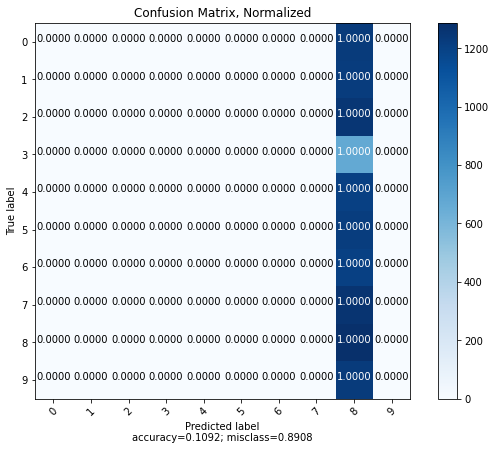

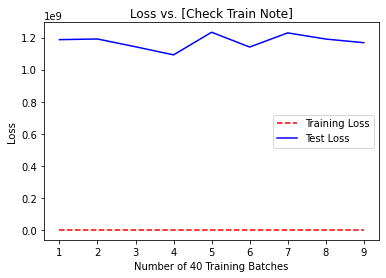

In [ ]:
train(base_model, 3, train_loader, test_loader, 0.003, criterion, print_every = 40, zero_base_line = True, enable_scheduler = False)

Device: cuda
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0003
    weight_decay: 0
)
Note: Train Loss is calculated after 40 batches of the train loader. While the test loss is calculated over the whole test_loader
For example: a sequence might be train for 40 batches then test on everything and then train for the next 40 batches then test on everything ... 
Epoch: 1/10 | Batch Number: 40 | Learning Rate: 0.00030000 | Train Loss: 85.37 | Train Accuracy 22.62% | Test Loss: 128.03 | Test Accuracy 25.81%
Epoch: 1/10 | Batch Number: 80 | Learning Rate: 0.00030000 | Train Loss: 80.68 | Train Accuracy 28.98% | Test Loss: 120.87 | Test Accuracy 31.56%
Epoch: 1/10 | Batch Number: 120 | Learning Rate: 0.00030000 | Train Loss: 76.48 | Train Accuracy 30.70% | Test Loss: 109.76 | Test Accuracy 37.90%
Epoch: 2/10 | Batch Number: 40 | Learning Rate: 0.00030000 | Train Loss: 68.49 | Train Accuracy 36.47% | Test Loss: 111.10 | Test Accuracy 36

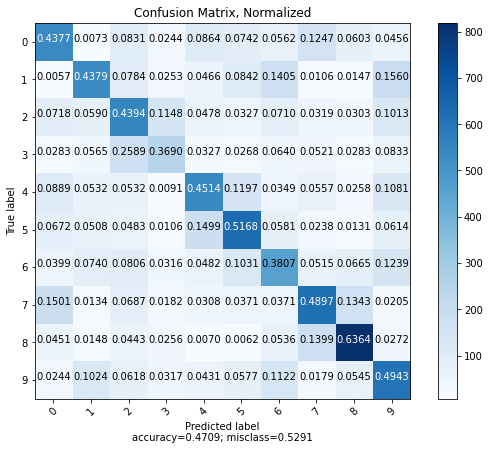

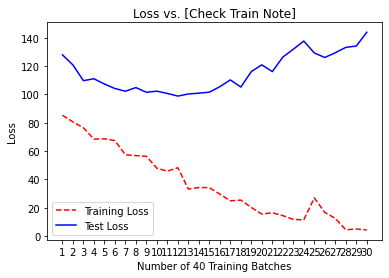

In [ ]:
train(base_model, 10, train_loader, test_loader, 3e-4, criterion, print_every = 40, enable_scheduler = False)

## Resnet Models Random Weights

In [25]:
def choose_resnet(model_name):

  assert type(model_name) == str

  resnet = eval("models.{}()".format(model_name))
  resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 1000),
    nn.ReLU(inplace = True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(1000, 500),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(500, 10))
  
  return resnet

In [26]:
#Instantiate all the resnet models
resnet50 = choose_resnet("resnet50")
wide_resnet50_2 = choose_resnet("wide_resnet50_2")
resnext50_32x4d = choose_resnet("resnext50_32x4d")

Device: cuda
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0003
    weight_decay: 0
)
Note: Train Loss is calculated after 40 batches of the train loader. While the test loss is calculated over the whole test_loader
For example: a sequence might be train for 40 batches then test on everything and then train for the next 40 batches then test on everything ... 
Epoch: 1/10 | Batch Number: 40 | Learning Rate: 0.00030000 | Train Loss: 94.02 | Train Accuracy 11.91% | Test Loss: 142.36 | Test Accuracy 11.50%
Epoch: 1/10 | Batch Number: 80 | Learning Rate: 0.00030000 | Train Loss: 88.82 | Train Accuracy 15.35% | Test Loss: 145.98 | Test Accuracy 17.74%
Epoch: 1/10 | Batch Number: 120 | Learning Rate: 0.00030000 | Train Loss: 85.90 | Train Accuracy 19.92% | Test Loss: 136.21 | Test Accuracy 21.15%
Epoch: 2/10 | Batch Number: 40 | Learning Rate: 0.00030000 | Train Loss: 85.08 | Train Accuracy 20.18% | Test Loss: 130.11 | Test Accuracy 21

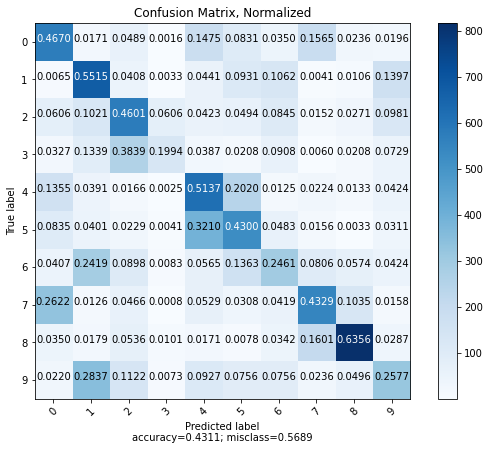

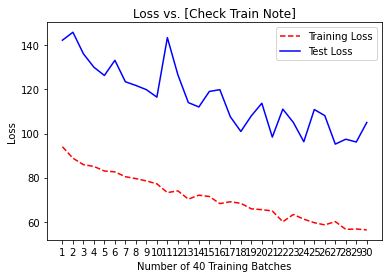

In [ ]:
train(resnet50, 10, train_loader, test_loader, 3e-4, criterion, print_every = 40, enable_scheduler = False)

Device: cuda
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0003
    weight_decay: 0
)
Note: Train Loss is calculated after 40 batches of the train loader. While the test loss is calculated over the whole test_loader
For example: a sequence might be train for 40 batches then test on everything and then train for the next 40 batches then test on everything ... 
Epoch: 1/10 | Batch Number: 40 | Learning Rate: 0.00030000 | Train Loss: 93.39 | Train Accuracy 11.52% | Test Loss: 138.82 | Test Accuracy 16.42%
Epoch: 1/10 | Batch Number: 80 | Learning Rate: 0.00030000 | Train Loss: 87.65 | Train Accuracy 17.81% | Test Loss: 133.78 | Test Accuracy 18.63%
Epoch: 1/10 | Batch Number: 120 | Learning Rate: 0.00030000 | Train Loss: 85.99 | Train Accuracy 19.61% | Test Loss: 129.29 | Test Accuracy 21.94%
Epoch: 2/10 | Batch Number: 40 | Learning Rate: 0.00030000 | Train Loss: 84.52 | Train Accuracy 20.03% | Test Loss: 127.99 | Test Accuracy 21

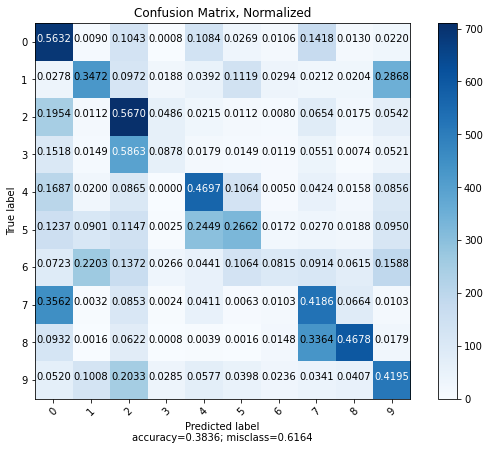

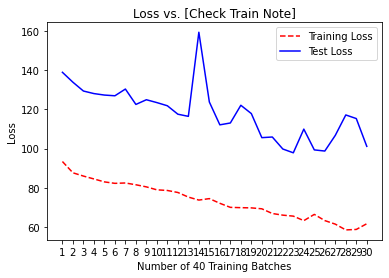

In [ ]:
train(wide_resnet50_2, 10, train_loader, test_loader, 3e-4, criterion, print_every = 40, enable_scheduler = False)

Device: cuda
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0003
    weight_decay: 0
)
Note: Train Loss is calculated after 40 batches of the train loader. While the test loss is calculated over the whole test_loader
For example: a sequence might be train for 40 batches then test on everything and then train for the next 40 batches then test on everything ... 
Epoch: 1/10 | Batch Number: 40 | Learning Rate: 0.00030000 | Train Loss: 94.36 | Train Accuracy 11.72% | Test Loss: 142.91 | Test Accuracy 10.97%
Epoch: 1/10 | Batch Number: 80 | Learning Rate: 0.00030000 | Train Loss: 90.67 | Train Accuracy 13.83% | Test Loss: 132.98 | Test Accuracy 19.01%
Epoch: 1/10 | Batch Number: 120 | Learning Rate: 0.00030000 | Train Loss: 87.11 | Train Accuracy 17.07% | Test Loss: 129.78 | Test Accuracy 21.81%
Epoch: 2/10 | Batch Number: 40 | Learning Rate: 0.00030000 | Train Loss: 83.87 | Train Accuracy 21.95% | Test Loss: 128.28 | Test Accuracy 22

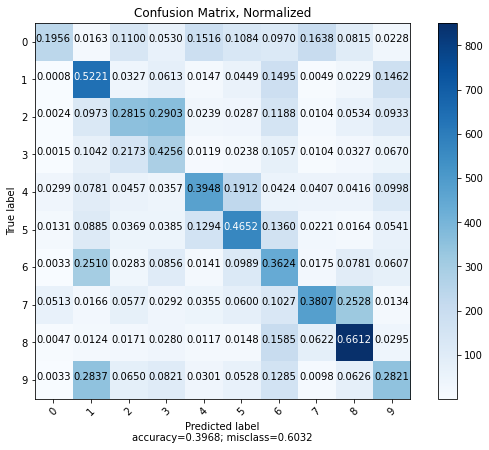

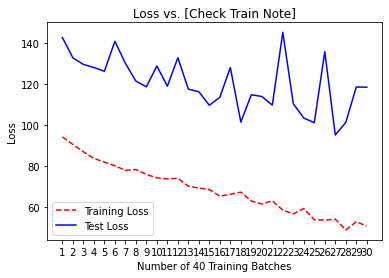

In [ ]:
train(resnext50_32x4d, 10, train_loader, test_loader, 3e-4, criterion, print_every = 40, enable_scheduler = False)

## Build new model using Xresnet, Ranger, Replacement to BatchNorm2d and more complexity in Image Processing.
https://analyticsindiamag.com/alternatives-batch-normalization-deep-learning/
https://towardsdatascience.com/xresnet-from-scratch-in-pytorch-e64e309af722
https://www.kaggle.com/nelsongriffiths/mish-activation-and-transfer-learning-pytorch
https://docs.fast.ai/vision.models.xresnet.html#xresnext34


In [128]:
# This optimzier combines RAdam with Look Ahead. 
from ranger import Ranger  

In [132]:
class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()
        
    def forward(self, input):
        return (input*torch.tanh(F.softplus(input)))

In [133]:
activation_function = Mish()
def mish_resnet50(resnet, act):

  resnet.relu = act
  resnet.layer1[0].relu = act
  resnet.layer1[1].relu = act
  resnet.layer1[2].relu = act
  resnet.layer2[0].relu = act 
  resnet.layer2[1].relu = act
  resnet.layer2[2].relu = act 
  resnet.layer2[3].relu = act 
  resnet.layer3[0].relu = act 
  resnet.layer3[1].relu = act 
  resnet.layer3[2].relu = act 
  resnet.layer3[3].relu = act 
  resnet.layer3[4].relu = act 
  resnet.layer3[5].relu = act 
  resnet.layer4[0].relu = act 
  resnet.layer4[1].relu = act 
  resnet.layer4[2].relu = act 
  resnet.fc[1] = act
  resnet.fc[4] = act

  return resnet

resnet50 = mish_resnet50(choose_resnet("resnet50"), activation_function)

In [134]:
train(resnet50, 5, train_loader, test_loader, 3e-4, criterion, weight_decay = 0.001)

Device: cuda
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0003
    lr: 0.0003
    weight_decay: 0.001
)
Note: Train Loss is calculated after 40 batches of the train loader. While the test loss is calculated over the whole test_loader
For example: a sequence might be train for 40 batches then test on everything and then train for the next 40 batches then test on everything ... 


RuntimeError: ignored

In [114]:
resnet50 = choose_resnet("resnet50")

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Device: cuda
Optimizer: Ranger (
Parameter Group 0
    N_sma_threshhold: 5
    alpha: 0.5
    betas: (0.95, 0.999)
    eps: 1e-05
    initial_lr: 0.0003
    k: 6
    lr: 0.0003
    step_counter: 0
    weight_decay: 5
)
Note: Train Loss is calculated after 40 batches of the train loader. While the test loss is calculated over the whole test_loader
For example: a sequence might be train for 40 batches then test on everything and then train for the next 40 batches then test on everything ... 
Epoch: 1/5 | Batch Number: 40 | Learning Rate: 0.00030000 | Train Loss: 63.00 | Train Accuracy 45.70% | Test Loss: 98.42 | Test Accuracy 46.88%
Epoch: 1/5 | Batch Number: 80 | Learning Rate: 0.00030000 | Train Loss: 63.56 | Train Accuracy 44.18% | Test Loss: 97.92 | Test Accuracy 46.93%
Epoch: 1/5 | Batch Number: 120 | Learning Rate: 0.00030000 | Train Loss: 64.13 | Train Accuracy 43.83% | Test Loss: 

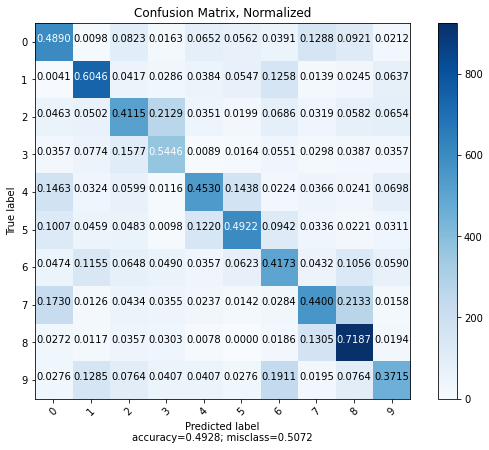

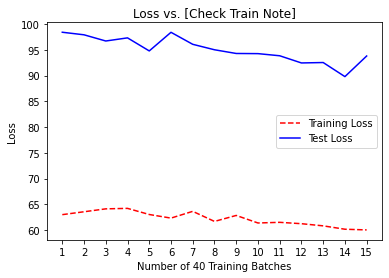

In [115]:
train(base_model, 5, train_loader, test_loader, 3e-4, criterion, range_optim = True, weight_decay = 5)

In [ ]:
def mish(x):
    return (x*torch.tanh(F.softplus(x)))

plt.plot(mish(list(range(100))))

TypeError: ignored

In [109]:
# activation_function = Mish()
# for layer_num in range(1, 5):
#   for ii, bottleneck in enumerate(eval("resnet50.layer{}".format(layer_num))):
#     locals()[eval("resnet50.layer{}{}.relu".format(layer_num, [ii]))] = 5

In [ ]:
def conv(inp, out, kernel_size=3, stride=1, bias=False):
    """Creates a convolution layer for `XResNet`."""
    return nn.Conv2d(inp, out, kernel_size, stride=stride, padding=kernel_size//2, bias=bias)

In [ ]:
conv(7, 10, 3)

Conv2d(7, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [ ]:
def conv_layer(inp, out, kernel_size = 3, stride=1, zero_batch_norm = False, use_activation = True, activation: torch.nn.Module = nn.ReLU(inplace=True)):
    """Creates a convolution block for `XResNet`."""
    batch_norm = nn.BatchNorm2d(n_filters)
    nn.init.constant_(batch_norm.weight, 0. if zero_batch_norm else 1.)
    layers = [conv(n_inputs, n_filters, kernel_size, stride=stride), batch_norm]
    if use_activation: layers.append(activation)
    return nn.Sequential(*layers)

In [ ]:
class XResNetBlock(nn.Module):
    """Creates the standard `XResNet` block."""
    def __init__(self, expansion: int, n_inputs: int, n_hidden: int, stride: int = 1,
                 activation: torch.nn.Module = nn.ReLU(inplace=True)):
        super().__init__()

        n_inputs = n_inputs * expansion
        n_filters = n_hidden * expansion

        # convolution path
        if expansion == 1:
            layers = [conv_layer(n_inputs, n_hidden, 3, stride=stride),
                      conv_layer(n_hidden, n_filters, 3, zero_batch_norm=True, use_activation=False)]
        else:
            layers = [conv_layer(n_inputs, n_hidden, 1),
                      conv_layer(n_hidden, n_hidden, 3, stride=stride),
                      conv_layer(n_hidden, n_filters, 1, zero_batch_norm=True, use_activation=False)]

        self.convs = nn.Sequential(*layers)

        # identity path
        if n_inputs == n_filters:
            self.id_conv = nn.Identity()
        else:
            self.id_conv = conv_layer(n_inputs, n_filters, kernel_size=1, use_activation=False)
        if stride == 1:
            self.pool = nn.Identity()
        else:
            self.pool = nn.AvgPool2d(2, ceil_mode=True)

        self.activation = activation

    def forward(self, x):
        return self.activation(self.convs(x) + self.id_conv(self.pool(x)))

In [ ]:
class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1000):
        # create the stem of the network
        n_filters = [c_in, (c_in+1)*8, 64, 64]
        stem = [conv_layer(n_filters[i], n_filters[i+1], stride=2 if i==0 else 1)
                for i in range(3)]

        # create `XResNet` blocks
        n_filters = [64//expansion, 64, 128, 256, 512]

        res_layers = [cls._make_layer(expansion, n_filters[i], n_filters[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2)
                      for i, l in enumerate(layers)]

        # putting it all together
        x_res_net = cls(*stem, nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                        *res_layers, nn.AdaptiveAvgPool2d(1), nn.Flatten(),
                        nn.Linear(n_filters[-1]*expansion, c_out)
                       )

        cls._init_module(x_res_net)
        return x_res_net

    @staticmethod
    def _make_layer(expansion, n_inputs, n_filters, n_blocks, stride):
        return nn.Sequential(
            *[XResNetBlock(expansion, n_inputs if i==0 else n_filters, n_filters, stride if i==0 else 1)
              for i in range(n_blocks)])

    @staticmethod
    def _init_module(module):
        if getattr(module, 'bias', None) is not None:
            nn.init.constant_(module.bias, 0)
        if isinstance(module, (nn.Conv2d,nn.Linear)):
            nn.init.kaiming_normal_(module.weight)
        # initialize recursively
        for l in module.children():
            XResNet._init_module(l)